In [1]:
import os
import pandas as pd
import shutil, os
import numpy as np
# import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
# from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
# from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session

import keras
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam

In [3]:
# Choose which GPU to use - HEX SERVER ONLY. Go to https://hex.cs.bath.ac.uk/usage for current usage
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# Prevent GPU memory overflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
#import multiprocessing
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.1
EPOCHS = 200
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
# NFOLDS = 5 # No of folds for cross validation
WORKERS = 16 #multiprocessing.cpu_count()-1 #32 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

In [5]:
DATASET_PATH = 'dataset/'
TRAIN_PATH = DATASET_PATH + 'train_file'
TEST_PATH = DATASET_PATH + 'test_file'

TRAIN_CSV_PATH = DATASET_PATH + '/train_file/train_label.csv'
TEST_CSV_PATH = DATASET_PATH + '/test_file/test_label.csv'

In [6]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

df_train['tags'] = df_train['tags'].apply(lambda x: x.split(' '))
df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

# print(df_train.head())
# print()
# print(df_test.head())

In [7]:
X_train_files = np.array(df_train['image_name'].tolist()) # filenames
X_train_files.reshape((X_train_files.shape[0], 1))
y_train = np.array(df_train['tags'].tolist()) # image tags (ground truth)

<ipython-input-7-6b6633285bcc>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_train = np.array(df_train['tags'].tolist()) # image tags (ground truth)


In [8]:
# check labels in tags and how many there are
tags = df_train['tags'].values

flat_list = [item for sublist in tags for item in sublist]
tags_unique, tags_count = np.unique(flat_list, return_counts=True)
labels = list(tags_unique)

print(labels)
print()
print(len(labels), "unique tags")

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']

17 unique tags


In [9]:
# plt.figure(figsize=(20, 20))
# res = [32, 64, 128, 256]
# NIMGS = 5
# train = df_train.reset_index()
# test = df_test.reset_index()

# for i in range(len(res)):
#     for j in range(NIMGS):
#         img = cv2.imread(os.path.join(TRAIN_PATH, df_train['image_name'][j+1]))
#         img = cv2.resize(img, (res[i], res[i]))
#         plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.title(df_train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]))
#         plt.axis('off')
    
# plt.show()

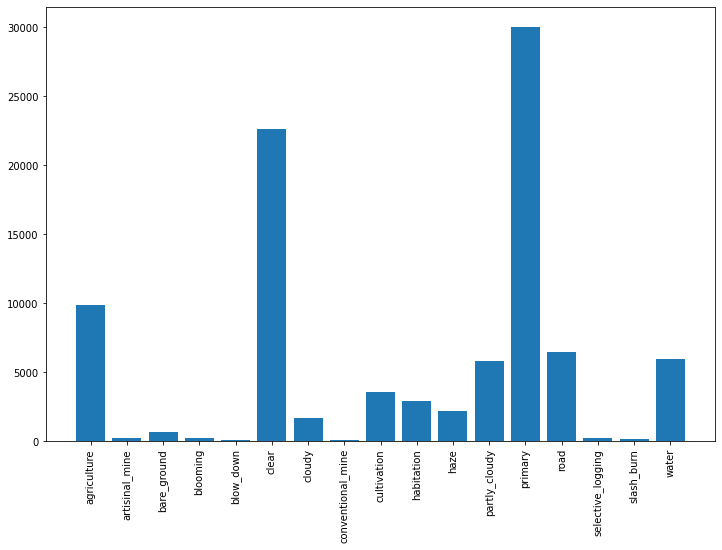

In [10]:
# Distribution of the labels

plt.figure(figsize=(12, 8))
            
plt.bar(range(len(tags_count)), list(tags_count), align='center')
plt.xticks(range(len(tags_count)), list(labels), rotation=90)

plt.show()

In [11]:
# Define learning curve and evaluation metric (f-2 Beta score):

def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# F-Beta Score
def fbeta_score_K(y_true, y_pred):
    beta = 2
    beta_squared = beta ** 2
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [12]:
#Define CNN model architecture:

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.1),

        Flatten(),

#         Dense(1024, activation='relu'),
        Dense(17, activation='sigmoid') 
    ])

    #optimizer = Adam(0.001, decay=0.0001)

    return model

model = create_model()

clear_session()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [13]:
# Run the model

X_train_files, X_val_files, y_train, y_val = train_test_split(X_train_files, y_train, test_size=0.2, random_state=0)

train_df = pd.DataFrame(list(zip(X_train_files, y_train)), columns = ['image_name', 'tags'])
val_df = pd.DataFrame(list(zip(X_val_files, y_val)), columns = ['image_name', 'tags'])

train_df['tags'] = train_df['tags']
val_df['tags'] = val_df['tags']

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=TRAIN_PATH,
    x_col='image_name',
    y_col='tags',
    #validate_filenames=False,
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=labels,
)
#print("train gen complete")
val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=TRAIN_PATH,
    x_col='image_name',
    y_col='tags',
    #validate_filenames=False,
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=labels,
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    directory=TEST_PATH,
    x_col='image_name',
    y_col=None,
    #validate_filenames=False,
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=labels,
    shuffle=False,
)

model_path = 'CNN_weights' + '.h5'

# clear_session()
# model = create_model()

adam = Adam(learning_rate=LR)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
]

history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

# DO NOT KNOW WHAT THIS IS FOR?
# for key, value in history.history.items():
#     fold[num_fold][key] = value 

model.load_weights(model_path)

y_pred = model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/50
203/203 [==============================] - 49s 208ms/step - loss: 0.3602 - fbeta_score_K: 0.4938 - val_loss: 0.2428 - val_fbeta_score_K: 0.5547
Epoch 2/50
203/203 [==============================] - 46s 218ms/step - loss: 0.2239 - fbeta_score_K: 0.5984 - val_loss: 0.2284 - val_fbeta_score_K: 0.5814
Epoch 3/50
203/203 [==============================] - 46s 218ms/step - loss: 0.2092 - fbeta_score_K: 0.6299 - val_loss: 0.2131 - val_fbeta_score_K: 0.6125
Epoch 4/50
203/203 [==============================] - 50s 224ms/step - loss: 0.2041 - fbeta_score_K: 0.6395 - val_loss: 0.1955 - val_fbeta_score_K: 0.6540
Epoch 5/50
203/203 [==============================] - 48s 229ms/step - loss: 0.1993 - fbeta_score_K: 0.6489 - val_loss: 0.1853 - val_fbeta_score_K: 0.6651
Epoch 6/50
203/203 [==================

In [20]:
import pandas as pd

train_history = pd.DataFrame(history.history)
train_history

,loss,fbeta_score_K,val_loss,val_fbeta_score_K,lr
0,0.281842,0.541820,0.242846,0.554749,0.0001
1,0.221260,0.605311,0.228432,0.581379,0.0001
2,0.209153,0.629833,0.213110,0.612543,0.0001
3,0.203016,0.640910,0.195541,0.653978,0.0001
4,0.195419,0.655334,0.185258,0.665144,0.0001
5,0.183448,0.678091,0.177660,0.668013,0.0001
6,0.175606,0.694043,0.172489,0.706339,0.0001
7,0.169295,0.706461,0.162591,0.725136,0.0001
8,0.164864,0.714876,0.166128,0.725193,0.0001
9,0.161139,0.722682,0.152536,0.728580,0.0001


In [22]:
train_history.to_csv('CNN_train_history.csv', sep=',')

In [ ]:
plt.plot(train_history['fbeta_score_K'])
plt.plot(train_history['val_fbeta_score_K'])
plt.title('model accuracy')
plt.ylabel('fbeta_score_K')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(train_history['loss'])
plt.plot(train_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### Calculating test accuracy

In [ ]:
y_pred[0]

In [ ]:
# makes labeled predictions with threshold

pred = []

for row in y_test:
    label = []
    for i, acc in enumerate(row):
        if acc >= THRES[0]:
            label.append(labels[i])
    pred.append(label)
    
print(pred[0])
            

In [ ]:
print(df_test['tags'][0])

In [ ]:
from sklearn.metrics import fbeta_score

def calc_acc(df_test):
    test = df_test['tags']
    pred = df_test['pred_tags'].apply(lambda x: x.split(' '))
    
    from sklearn.preprocessing import MultiLabelBinarizer
    
    mlb = MultiLabelBinarizer()
    test = mlb.fit_transform(test)
    pred = mlb.transform(pred)
    score = fbeta_score(test,pred,beta=2,average='weighted')
    return score

acc_score = calc_acc(df_test)
print("Accuracy Score: ", acc_score)